In [ ]:
Generate scale free trees and random scale free networkb

In [ ]:
using Graphs

In [ ]:
using Graphs, Random
using CategoricalArrays
using StatsBase,LsqFit
using Plots
using GraphMakie, CairoMakie, NetworkLayout, Colors


In [ ]:
# Function to generate an initial scale-free network using preferential attachment
function generate_scale_free_network_optimized(n::Int, m::Int)
    g = SimpleGraph(n)
    for i in 2:n
        add_edge!(g, i, rand(1:i-1))  # Connect each new node to a random existing node
    end
    add_edge!(g, 1, 2)  # Start with an initial edge
    degrees = fill(1,m)  # Track degrees
    node_list = collect(1:m)  # List for preferential selection
    
    for new_node in 3:n
        targets = Set{Int}()
        
        while length(targets) < m
            selected_node = rand(node_list)  # Fast sampling from weighted list
            push!(targets, selected_node)
        end
        
        for target in targets
            add_edge!(g, new_node, target)
            degrees[target] += 1
            push!(node_list, target)  # Update selection list
        end
        
        push!(degrees, m)
        append!(node_list, fill(new_node, m))  # Maintain weighted list for future selections
    end
    return g
end


In [ ]:
g = generate_scale_free_network_optimized(100000, 5)
d = degree(g)

In [ ]:
d = degree(g)
plot1 = Figure();
ax, plt = graphplot(plot1[1,1], g, layout=Spring())
display(plot1)



In [ ]:
# logbin the data
bin_edges = 10 .^(range(log10(minimum(d)),log10(maximum(d));length=20))
hist = fit(Histogram,d, bin_edges)
edge_ = hist.edges[1]
size = 0.5*(edge_[1:end-1]+edge_[2:end])
binwidth = diff(edge_)
prob = hist.weights./sum(hist.weights)./binwidth
index = findall(x -> x != 0.0, prob)

# plot the degree distribution
f(x,p) = p[1] .+ x.* p[2]
curve_fitted = curve_fit(f, log10.(size[index]), log10.(prob[index]), [1.0, -3.0])
h2 = Plots.scatter(size[index],prob[index],xscale=:log10,yscale=:log10,label="Degree Distribution",xlabel="Degree",ylabel="Frequency",legend=:outerright)
curve_fitted.param[2]
f2(x) = 10^(curve_fitted.param[1]) .*x.^ curve_fitted.param[2]
Plots.plot!(h2,1:maximum(size),f2,linestyle=:dash,linewidth=2,label="Power Law Fit Slope=$(round.(curve_fitted.param[2],digits=3)) ")



In [ ]:
using Random, Graphs, GraphPlot, Plots

In [ ]:

N = 100  # Number of nodes
d = 2  # Dimension (2D case)
L = ceil(Int, sqrt(N))  # Grid size to form a square lattice
delta = 3.0  # Distance exponent controlling spatial constraints
kt = 3  # Target degree (varies with δ, see paper)

# Generate a 2D lattice of node positions
positions = [(x, y) for x in 1:L for y in 1:L][1:N]

# Create an empty graph
G = SimpleGraph(N)

# Function to calculate Euclidean distance
function euclidean_distance(p1, p2)
    return sqrt((p1[1] - p2[1])^2 + (p1[2] - p2[2])^2)
end

# Normalized probability of connecting at distance r
function connection_probability(r, delta, d=2)
    return (r^(d-1) * r^(-delta))
end

# Normalize the probability over [1, L]
function normalize_probability(delta, d, L)
    integral = sum(connection_probability(r, delta, d) for r in 1:L)
    return 1.0 / integral
end

c = normalize_probability(delta, d, L)  # Normalization constant

# Connect nodes based on the power-law probability distribution
for i in 1:N
    potential_neighbors = [(j, euclidean_distance(positions[i], positions[j])) for j in 1:N if j != i]
    
    # Compute probabilities
    probabilities = [c * connection_probability(r, delta, d) for (_, r) in potential_neighbors]
    
    # Normalize probabilities
    total_prob = sum(probabilities)
    probabilities = [p / total_prob for p in probabilities]
    
    # Select k_t neighbors based on probability
    chosen_indices = sample(1:length(potential_neighbors), Weights(probabilities), kt)
    
    for idx in chosen_indices
        j, _ = potential_neighbors[idx]
        add_edge!(G, i, j)
    end
end

# Extract node positions for visualization
x_pos = [pos[1] for pos in positions]
y_pos = [pos[2] for pos in positions]


In [ ]:
# Plot network
for e in edges(G)
    i, j = src(e), dst(e)
    plot!([x_pos[i], x_pos[j]], [y_pos[i], y_pos[j]], lw=1, color=:gray)
end

scatter!(x_pos, y_pos, markersize=5, color=:blue, label="Nodes")
title!("2D Spatially Embedded Network (Kosmidis et al.)")
xlabel!("X")
ylabel!("Y")

In [ ]:
G = SimpleGraph(100)

In [31]:
positions = [(x, y) for x in 1:L for y in 1:L];

In [33]:
using Random, Graphs, GraphPlot, Plots, StatsBase

# Set parameters
N = 500  # Number of nodes
d = 2  # Dimension (2D case)
L = ceil(Int, sqrt(N))  # Grid size to form a square lattice
delta = 5  # Distance exponent controlling spatial constraints
kt = 1 # Target degree (varies with δ, see paper)

# Generate a 2D lattice of node positions
positions = [(x, y) for x in 1:L for y in 1:L];

# Create an empty graph
G = SimpleGraph(N)

# Function to calculate Euclidean distance
function euclidean_distance(p1, p2)
    return sqrt((p1[1] - p2[1])^2 + (p1[2] - p2[2])^2)
end

# Normalized probability of connecting at distance r
function connection_probability(r, delta::Float64, d=2.0)
    return (r^(d-1) * r^(-delta))
end

# Normalize the probability over [1, L]
function normalize_probability(delta, d, L)
    integral = sum(connection_probability(r, delta, d) for r in Float64.(collect(1:L)))
    return 1.0 / integral
end

c = normalize_probability(delta, d, L)  # Normalization constant

# Connect nodes based on the power-law probability distribution
for i in 1:N
    potential_neighbors = [(j, euclidean_distance(positions[i], positions[j])) for j in 1:N if j != i]
    
    # Compute probabilities
    probabilities = [c * connection_probability(r, delta, d) for (_, r) in potential_neighbors]
    
    # Normalize probabilities
    total_prob = sum(probabilities)
    probabilities = [p / total_prob for p in probabilities]
    
    # Select k_t neighbors based on probability
    chosen_indices = sample(1:length(potential_neighbors), Weights(probabilities), kt)
    
    for idx in chosen_indices
        j, _ = potential_neighbors[idx]
        add_edge!(G, i, j)
    end
end

# Extract node positions for visualization
x_pos = [pos[1] for pos in positions]
y_pos = [pos[2] for pos in positions]




529-element Vector{Int64}:
  1
  2
  3
  4
  5
  6
  7
  8
  9
 10
  ⋮
 15
 16
 17
 18
 19
 20
 21
 22
 23

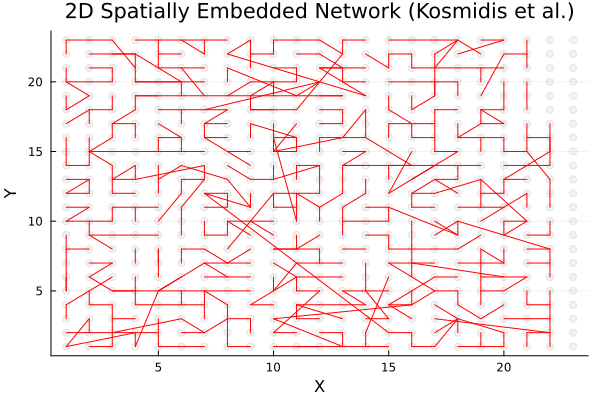

In [35]:
h = Plots.scatter(x_pos, y_pos, markersize=4, color=:grey, alpha=0.1,label="")
for e in collect(edges(G))  # Fix: collect edges for iteration
    i, j = src(e), dst(e)
    plot!(h,[x_pos[i], x_pos[j]], [y_pos[i], y_pos[j]], lw=1, color=:red, labels="")
end

title!("2D Spatially Embedded Network (Kosmidis et al.)")
xlabel!("X")
ylabel!("Y")

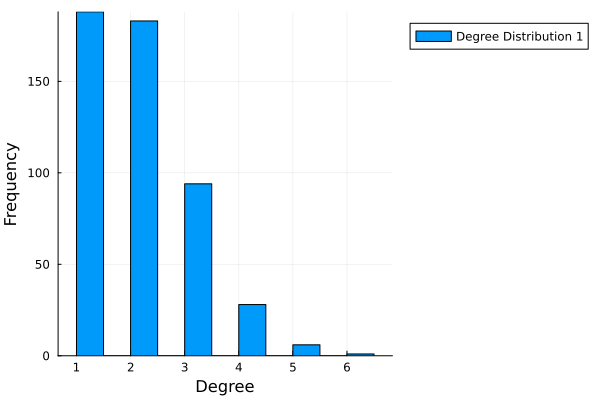

In [24]:
d = degree(G)
histogram(d, bins=20, label="Degree Distribution $kt", xlabel="Degree", ylabel="Frequency", legend=:outertopright)